# Training a ConvNet PyTorch

In this notebook, you'll learn how to use the powerful PyTorch framework to specify a conv net architecture and train it on the human action recognition dataset. 


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader,sampler,Dataset
import torchvision.datasets as dset
import torchvision.transforms as T
import timeit
from PIL import Image
import os
import numpy as np
import scipy.io


In [2]:
!pip install torchvision

## What's this PyTorch business?

* When using a framework like PyTorch or TensorFlow you can harness the power of the GPU for your own custom neural network architectures without having to write CUDA code directly.
* this notebook will walk you through much of what you need to do to train models using pytorch. if you want to learn more or need further clarification on topics that aren't fully explained here, here are 2 good Pytorch tutorials. 1): http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html 2)http://pytorch.org/tutorials/beginner/pytorch_with_examples.html
* It's not necessary to have a GPU for this homework, using a GPU can make your code run faster.


## Load Datasets

In this part, we will load the action recognition dataset for the neural network. In order to load data from our custom dataset, we need to write a custom Dataloader. If you put hw6_data.mat, /valClips,/trainClips,/testClips under the folder of ./data/ , you do not need to change anything in this part.

First, load the labels of the dataset, you should write your path of the hw6_data.mat file.

In [3]:
label_mat=scipy.io.loadmat('./data/hw6_data.mat')
label_train=label_mat['trLb']
print(len(label_train))
label_val=label_mat['valLb']
print(len(label_val))

7770
2230


In [ ]:
# print(label_mat.keys())
# labels it is from 0 to 10 categories

In [ ]:
# label_mat contains only labels 

In [4]:
!pip install pandas
import pandas as pd
np.unique(label_val)

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.], dtype=float32)

### Dataset class

torch.utils.data.Dataset is an abstract class representing a dataset. The custom dataset should inherit Dataset and override the following methods:

    __len__ so that len(dataset) returns the size of the dataset.
    __getitem__ to support the indexing such that dataset[i] can be used to get ith sample

Let’s create a dataset class for our action recognition dataset. We will read images in __getitem__. This is memory efficient because all the images are not stored in the memory at once but read as required.

Sample of our dataset will be a dict {'image':image,'img_path':img_path,'Label':Label}. Our datset will take an optional argument transform so that any required processing can be applied on the sample. 

In [5]:
class ActionDataset(Dataset):
    """Action dataset."""

    def __init__(self,  root_dir,labels=[], transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            labels(list): labels if images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.length=len(os.listdir(self.root_dir))
        self.labels=labels
    def __len__(self):
        return self.length*3

    def __getitem__(self, idx):
        folder=int(idx/3)+1
        imidx=idx%3+1
        folder=format(folder,'05d')
        imgname=str(imidx)+'.jpg'
        img_path = os.path.join(self.root_dir,
                                folder,imgname)
        image = Image.open(img_path)
        if len(self.labels)!=0:
            Label=self.labels[int(idx/3)][0]-1
        if self.transform:
            image = self.transform(image)
        if len(self.labels)!=0:
            sample={'image':image,'img_path':img_path,'Label':Label}
        else:
            sample={'image':image,'img_path':img_path}
        return sample
  

Iterating over the dataset by a for loop.

In [6]:
image_dataset=ActionDataset(root_dir='./data/trainClips/',\
                            labels=label_train,transform=T.ToTensor())

#iterating though the dataset
for i in range(10):
    sample=image_dataset[i]
    print(sample['image'].shape)
    print(sample['Label'])
    print(sample['img_path'])
     
   

torch.Size([3, 64, 64])
0.0
./data/trainClips/00001/1.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00001/2.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00001/3.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00002/1.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00002/2.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00002/3.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00003/1.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00003/2.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00003/3.jpg
torch.Size([3, 64, 64])
0.0
./data/trainClips/00004/1.jpg


We can iterate over the created dataset with a 'for' loop as before. However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

* Batching the data
* Shuffling the data
* Load the data in parallel using multiprocessing workers.

torch.utils.data.DataLoader is an iterator which provides all these features. 

In [7]:
image_dataloader = DataLoader(image_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

for i,sample in enumerate(image_dataloader):
    sample['image']=sample['image']
    print(i,sample['image'].shape,sample['img_path'],sample['Label'])
    if i>20: 
        break

0 torch.Size([4, 3, 64, 64]) ['./data/trainClips/01984/1.jpg', './data/trainClips/03954/3.jpg', './data/trainClips/02063/3.jpg', './data/trainClips/06201/3.jpg'] tensor([2., 4., 2., 7.], dtype=torch.float64)
1 torch.Size([4, 3, 64, 64]) ['./data/trainClips/00962/1.jpg', './data/trainClips/03399/2.jpg', './data/trainClips/07682/2.jpg', './data/trainClips/02981/1.jpg'] tensor([1., 3., 9., 3.], dtype=torch.float64)
2 torch.Size([4, 3, 64, 64]) ['./data/trainClips/04184/3.jpg', './data/trainClips/00396/3.jpg', './data/trainClips/05571/2.jpg', './data/trainClips/01802/2.jpg'] tensor([5., 0., 6., 1.], dtype=torch.float64)
3 torch.Size([4, 3, 64, 64]) ['./data/trainClips/04393/1.jpg', './data/trainClips/03895/2.jpg', './data/trainClips/06360/2.jpg', './data/trainClips/04863/3.jpg'] tensor([5., 4., 7., 5.], dtype=torch.float64)
4 torch.Size([4, 3, 64, 64]) ['./data/trainClips/02305/2.jpg', './data/trainClips/06525/2.jpg', './data/trainClips/01523/3.jpg', './data/trainClips/06621/2.jpg'] tensor

Dataloaders for the training, validationg and testing set. 

In [8]:
image_dataset_train=ActionDataset(root_dir='./data/trainClips/',labels=label_train,transform=T.ToTensor())

image_dataloader_train = DataLoader(image_dataset_train, batch_size=32,
                        shuffle=True, num_workers=4)
image_dataset_val=ActionDataset(root_dir='./data/valClips/',labels=label_val,transform=T.ToTensor())

image_dataloader_val = DataLoader(image_dataset_val, batch_size=32,
                        shuffle=False, num_workers=4)
image_dataset_test=ActionDataset(root_dir='./data/testClips/',labels=[],transform=T.ToTensor())

image_dataloader_test = DataLoader(image_dataset_test, batch_size=32,
                        shuffle=False, num_workers=4)

In [9]:
dtype = torch.FloatTensor # the CPU datatype
# Constant to control how frequently we print train loss
print_every = 100
# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

## Example Model

### Some assorted tidbits

Let's start by looking at a simple model. First, note that PyTorch operates on Tensors, which are n-dimensional arrays functionally analogous to numpy's ndarrays, with the additional feature that they can be used for computations on GPUs.

We'll provide you with a Flatten function, which we explain here. Remember that our image data (and more relevantly, our intermediate feature maps) are initially N x C x H x W, where:
* N is the number of datapoints
* C is the number of image channels. 
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we input  data into fully connected affine layers, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "Flatten" operation to collapse the C x H x W values per representation into a single long vector. The Flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly). 

In [10]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in PyTorch -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up.  nn.Sequential is a container which applies each layer
one after the other.

In this example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Cross-Entropy loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 10092 and 10.


In [10]:
# Here's where we define the architecture of the model... 
simple_model = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=7, stride=2),
#     N*C*H*W=====> (N=1 if you are sending only one image but here N=32 batch) *3*64*64 
#     64 is the input size, 64 is the input size ----- (n+2p-f)/s + 1-----(64-7)/2 + 1--- 32*32*29*29
#     torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1,
#     32*(64-7/2 + 1)*(64-7/2 + 1)-----32*29*29----26912 instead of 10092 should be the output.
                nn.ReLU(inplace=True),
                Flatten(), # see above for explanation
                nn.Linear(26912, 10), # affine layer
              )

# torch.randn(*sizes, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False)
# Set the type of all data in this model to be FloatTensor 
simple_model.type(dtype)

loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(simple_model.parameters(), lr=1e-2) # lr sets the learning rate of the optimizer

PyTorch supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers: http://pytorch.org/docs/nn.html
* Activations: http://pytorch.org/docs/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/optim.html#algorithms

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the PyTorch documentation and configuring your own model. 

Using the code provided above as guidance, and using the following PyTorch documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 8 filters and stride of 1
* ReLU Activation Layer
* 2x2 Max Pooling layer with a stride of 2
* 7x7 Convolutional Layer with 16 filters and stride of 1
* ReLU Activation Layer
* 2x2 Max Pooling layer with a stride of 2
* Flatten the feature map
* ReLU Activation Layer
* Affine layer to map input units to 10 outputs, you need to figure out the input size here.


In [11]:
fixed_model_base = nn.Sequential( 
    #########1st TODO  (10 points)###################
#     torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1,
#     32 is the mini batch size,3,64,64 is my input size
#     8*((64-7)/1 +1)*((64-7)/1 + 1)------8*58*58
            nn.Conv2d(3, 8, kernel_size = 7, stride = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
#floor[(W1-f)/s +1] is the size for this.
# 8*(29)*29
#     It is reducing the size of the 8*29*29
    #Original size is divided by 4 as the size of the kernel is 4 and the stride horizontal and bottom is 2, so it is leaving
            nn.Conv2d(8, 16, kernel_size = 7, stride = 1),
#16* (29-7 + 1) *(29-7 + 1)-----16*23*23  
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
#16*11*11
            Flatten(),
#1936 is the size of each example after flattening
            nn.ReLU(inplace = True),
#class torch.nn.Linear(in_features, out_features, bias=True)[source]
# Applies a linear transformation to the incoming data: y=xAT+b
# Input: (N,∗,in_features)
# Output: (N,∗,out_features)
#  where all but the last dimension are the same shape as the input.
# 32*10 is the final output.
            nn.Linear(1936, 10)
    ####################################
            )
fixed_model = fixed_model_base.type(dtype)



To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 32 x 10, since our batches have size 32 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [12]:
## Now we're going to feed a random batch into the model you defined and make sure the output is the right size
x = torch.randn(32, 3, 64, 64).type(dtype)

x_var = Variable(x.type(dtype)) # Construct a PyTorch Variable out of your input data
ans = fixed_model(x_var)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
print(np.array(ans.size()))
np.array_equal(np.array(ans.size()), np.array([32, 10]))   


[32 10]


True

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the fixed_model_base we provided above).

Make sure you understand how each PyTorch function used below corresponds to what you implemented in your custom neural network implementation.

Note that because we are not resetting the weights anywhere below, if you run the cell multiple times, you are effectively training multiple epochs (so your performance should improve).

First, set up an RMSprop optimizer (using a 1e-4 learning rate) and a cross-entropy loss function:

In [13]:
################ 2nd TODO  (5 points)##################
optimizer=optim.RMSprop(fixed_model.parameters(), lr=1e-4)
loss_fn=nn.CrossEntropyLoss().type(dtype)

In [14]:
type(image_dataloader_train)   

torch.utils.data.dataloader.DataLoader

In [15]:
# This sets the model in "training" mode. 
# This is relevant for some layers that may have different behavior
# in training mode vs testing mode, such as Dropout and BatchNorm. 
fixed_model.train()

# Load one batch at a time.
for t, sample in enumerate(image_dataloader_train):
    x_var = Variable(sample['image'])
    #print(type(x_var.data))
    #print(x_var.shape)
    y_var = Variable(sample['Label']).long()
    # This is the forward pass: predict the scores for each class, for each x in the batch.
    scores = fixed_model(x_var)
    
    # Use the correct y values and the predicted y values to compute the loss.
    loss = loss_fn(scores, y_var)
    
    if (t + 1) % print_every == 0:
        print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

    # Zero out all of the gradients for the variables which the optimizer will update.
    optimizer.zero_grad()
    
    # This is the backwards pass: compute the gradient of the loss with respect to each 
    # parameter of the model.
    loss.backward()
    
    # Actually update the parameters of the model using the gradients computed by the backwards pass.
    optimizer.step()
   

t = 100, loss = 1.7742
t = 200, loss = 1.5764
t = 300, loss = 1.1748
t = 400, loss = 1.5502
t = 500, loss = 1.3348
t = 600, loss = 1.1555
t = 700, loss = 1.1982


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/ipykernel/__main__.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Now you've seen how the training process works in PyTorch. To save you writing boilerplate code, we're providing the following helper functions to help you train for multiple epochs and check the accuracy of your model:

In [12]:
def train(model, loss_fn, optimizer, dataloader, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, sample in enumerate(dataloader):
            x_var = Variable(sample['image'])
            y_var = Variable(sample['Label'].long())
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def check_accuracy(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for t, sample in enumerate(loader):
        x_var = Variable(sample['image'])
        y_var = sample['Label']
        #y_var=y_var.cpu()
        scores = model(x_var)
        _, preds = scores.data.max(1)#scores.data.cpu().max(1)
        #print(preds)
        #print(y_var)
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    

### Check the accuracy of the model.

Let's see the train and check_accuracy code in action -- feel free to use these methods when evaluating the models you develop below.

You should get a training loss of around 1.0-1.2, and a validation accuracy of around 50-60%. As mentioned above, if you re-run the cells, you'll be training more epochs, so your performance will improve past these numbers.

But don't worry about getting these numbers better -- this was just practice before you tackle designing your own model.

In [17]:
torch.random.manual_seed(12345)
fixed_model.cpu()
fixed_model.apply(reset) 
fixed_model.train() 
train(fixed_model, loss_fn, optimizer,image_dataloader_train, num_epochs=20) 
check_accuracy(fixed_model, image_dataloader_train)# check accuracy on the training set


Starting epoch 1 / 20
t = 100, loss = 2.2909
t = 200, loss = 2.2482
t = 300, loss = 2.1093
t = 400, loss = 1.8647
t = 500, loss = 1.7454
t = 600, loss = 1.5619
t = 700, loss = 1.5676
Starting epoch 2 / 20


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


t = 100, loss = 1.8257
t = 200, loss = 1.4317
t = 300, loss = 1.0852
t = 400, loss = 1.0638
t = 500, loss = 1.1948
t = 600, loss = 1.0566
t = 700, loss = 1.0145
Starting epoch 3 / 20
t = 100, loss = 0.9957
t = 200, loss = 1.1713
t = 300, loss = 0.6351
t = 400, loss = 1.1693
t = 500, loss = 0.9544
t = 600, loss = 0.8443
t = 700, loss = 0.6936
Starting epoch 4 / 20
t = 100, loss = 0.5383
t = 200, loss = 0.4932
t = 300, loss = 0.5882
t = 400, loss = 0.8857
t = 500, loss = 0.9050
t = 600, loss = 0.6130
t = 700, loss = 0.5943
Starting epoch 5 / 20
t = 100, loss = 0.7920
t = 200, loss = 0.7090
t = 300, loss = 0.5724
t = 400, loss = 0.7165
t = 500, loss = 0.3786
t = 600, loss = 0.4419
t = 700, loss = 0.4991
Starting epoch 6 / 20
t = 100, loss = 0.3843
t = 200, loss = 0.6913
t = 300, loss = 0.2980
t = 400, loss = 0.3216
t = 500, loss = 0.4289
t = 600, loss = 0.3761
t = 700, loss = 0.4739
Starting epoch 7 / 20
t = 100, loss = 0.4589
t = 200, loss = 0.2663
t = 300, loss = 0.4864
t = 400, loss = 

### Don't forget the validation set!

And note that you can use the check_accuracy function to evaluate on the validation set, by passing **image_dataloader_val** as the second argument to check_accuracy. The accuracy on validation set is arround 40-50%.

In [18]:
check_accuracy(fixed_model, image_dataloader_val)#check accuracy on the validation set

Got 3691 / 6690 correct (55.17)


In [19]:
def Evalmodel(model, data, num_epochs_to_run = 10):
    optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
    #optimizer = optim.Adam(model.parameters(), lr = 1e-4) 
    loss_fn = nn.CrossEntropyLoss().type(dtype)
    train_Acc = train(model, loss_fn, optimizer,data, num_epochs=num_epochs_to_run) 
    return train_Acc

In [ ]:
fix_model_1 = nn.Sequential( 
            nn.Conv2d(3, 8, kernel_size = 6, stride = 1),
#8*59*59
            nn.BatchNorm2d(8),
    
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
    #8*29*29
            nn.Conv2d(8, 16, kernel_size = 4, stride = 1),
    
#     16*26*26
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
#     16*13*13
    
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1),
    
#     32*11*11
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
    #32*5*5----800
    
#             nn.Conv2d(32, 32, kernel_size = 3, stride = 1),
# #     32*3*3
#             nn.BatchNorm2d(32),
#             nn.ReLU(inplace = True),
#             nn.MaxPool2d(2, stride = 2),
# #     32*1*1
    
    
            Flatten(),
            nn.ReLU(inplace = True),
            nn.Linear(800, 10)
            )
model_1 = fix_model_1.type(dtype)

In [ ]:
model = model_1
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().type(dtype)

train(model, loss_fn, optimizer,image_dataloader_train, num_epochs=8) 
check_accuracy(model, image_dataloader_val)

In [ ]:
fix_model_normed = nn.Sequential( 
            nn.Conv2d(3, 8, kernel_size = 6, stride = 1),
#     8*59*59
            nn.BatchNorm2d(8),    
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
    #8*29*29
            nn.Conv2d(8, 16, kernel_size = 4, stride = 1),
#     16*26*26
            nn.BatchNorm2d(16),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
#     16*13*13
            nn.Conv2d(16, 32, kernel_size = 3, stride = 1),
#     32*11*11
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(2, stride = 2),
    #32*5*5----800
            nn.Conv2d(32, 32, kernel_size = 3, stride = 1),
#     32*3*3
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),
#             nn.MaxPool2d(2, stride = 2),
#     32*1*1
            Flatten(),
            nn.ReLU(inplace = True),
            nn.Linear(288, 10)
            )
model_2 = fix_model_normed.type(dtype)
model = model_2
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().type(dtype)

train(model, loss_fn, optimizer,image_dataloader_train, num_epochs=8) 
check_accuracy(model, image_dataloader_val)

In [14]:
#Model 3
fix_model_normed = nn.Sequential(     
    nn.Conv2d(3, 32, kernel_size=5, stride=1),
#     32*60*60
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, stride = 2),
    #32*30*30
    
                nn.BatchNorm2d(32),
                nn.Dropout2d(0.1),
                nn.Conv2d(32, 24, kernel_size=5, stride=1),
    #24*26*26
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, stride = 2),
                nn.BatchNorm2d(24),
    #24*13*13
                nn.Dropout2d(0.2),
                nn.Conv2d(24, 20, kernel_size=4, stride=1),
#     20*10*10
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, stride=2),
    #20*5*5
                nn.BatchNorm2d(20),
                Flatten(),
                nn.Linear(500, 100),
                nn.Linear(100, 50),
                nn.Linear(50, 10),
                nn.LogSoftmax()
    )

# Whether the 
model_3 = fix_model_normed.type(dtype)
model = model_3
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().type(dtype)
train(model, loss_fn, optimizer,image_dataloader_train, num_epochs=8) 
check_accuracy(model, image_dataloader_val)

Starting epoch 1 / 8


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


t = 100, loss = 1.5696
t = 200, loss = 1.3600
t = 300, loss = 1.2169
t = 400, loss = 0.7267
t = 500, loss = 0.6851
t = 600, loss = 1.0963
t = 700, loss = 0.6028
Starting epoch 2 / 8
t = 100, loss = 0.4983
t = 200, loss = 0.5397
t = 300, loss = 0.2959
t = 400, loss = 0.3556
t = 500, loss = 0.7853
t = 600, loss = 0.4164
t = 700, loss = 0.3157
Starting epoch 3 / 8
t = 100, loss = 0.6906
t = 200, loss = 0.2663
t = 300, loss = 0.1697
t = 400, loss = 0.2484
t = 500, loss = 0.3311
t = 600, loss = 0.3446
t = 700, loss = 0.2819
Starting epoch 4 / 8
t = 100, loss = 0.2633
t = 200, loss = 0.3199
t = 300, loss = 0.0340
t = 400, loss = 0.1479
t = 500, loss = 0.3374
t = 600, loss = 0.1348
t = 700, loss = 0.1286
Starting epoch 5 / 8
t = 100, loss = 0.2852
t = 200, loss = 0.0878
t = 300, loss = 0.2888
t = 400, loss = 0.2161
t = 500, loss = 0.1021
t = 600, loss = 0.1929
t = 700, loss = 0.1308
Starting epoch 6 / 8
t = 100, loss = 0.1294
t = 200, loss = 0.2911
t = 300, loss = 0.1636
t = 400, loss = 0.218

In [16]:
#Model 4
fix_model_normed = nn.Sequential(
    nn.Conv2d(3, 200, kernel_size=10, stride=3),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(3, stride = 1),
                nn.BatchNorm2d(200),
                nn.Dropout2d(0.1),
                nn.Conv2d(200, 100, kernel_size=5, stride=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(3, stride = 1),
                nn.BatchNorm2d(100),
                nn.Dropout2d(0.2),
                nn.Conv2d(100, 50, kernel_size=3, stride=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, stride=1),
                nn.BatchNorm2d(50),
                Flatten(),
                nn.Linear(200, 100),
                nn.Linear(100, 50),
                nn.Linear(50, 10),
                nn.LogSoftmax())

# Whether the 
model_4 = fix_model_normed.type(dtype)
model = model_4
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().type(dtype)
train(model, loss_fn, optimizer,image_dataloader_train, num_epochs=8) 
check_accuracy(model, image_dataloader_val)

Starting epoch 1 / 8


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


t = 100, loss = 1.2613
t = 200, loss = 0.6819
t = 300, loss = 0.4639
t = 400, loss = 0.5367
t = 500, loss = 0.5016
t = 600, loss = 0.2766
t = 700, loss = 0.2215
Starting epoch 2 / 8
t = 100, loss = 0.2786
t = 200, loss = 0.0966
t = 300, loss = 0.2408
t = 400, loss = 0.1344
t = 500, loss = 0.2224
t = 600, loss = 0.0710
t = 700, loss = 0.1581
Starting epoch 3 / 8
t = 100, loss = 0.0470
t = 200, loss = 0.3320
t = 300, loss = 0.0795
t = 400, loss = 0.0880
t = 500, loss = 0.1454
t = 600, loss = 0.0427
t = 700, loss = 0.1762
Starting epoch 4 / 8
t = 100, loss = 0.1313
t = 200, loss = 0.0656
t = 300, loss = 0.0636
t = 400, loss = 0.1260
t = 500, loss = 0.1332
t = 600, loss = 0.1102
t = 700, loss = 0.1367
Starting epoch 5 / 8
t = 100, loss = 0.0400
t = 200, loss = 0.1231
t = 300, loss = 0.1657
t = 400, loss = 0.1659
t = 500, loss = 0.0333
t = 600, loss = 0.0214
t = 700, loss = 0.1139
Starting epoch 6 / 8
t = 100, loss = 0.2570
t = 200, loss = 0.0290
t = 300, loss = 0.1436
t = 400, loss = 0.090

In [18]:
train(model, loss_fn, optimizer,image_dataloader_train, num_epochs=2)

Starting epoch 1 / 2


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


t = 100, loss = 0.0463
t = 200, loss = 0.0179
t = 300, loss = 0.0107
t = 400, loss = 0.0072
t = 500, loss = 0.0083
t = 600, loss = 0.0647
t = 700, loss = 0.0027
Starting epoch 2 / 2
t = 100, loss = 0.0328
t = 200, loss = 0.2204
t = 300, loss = 0.0447
t = 400, loss = 0.0643
t = 500, loss = 0.0627
t = 600, loss = 0.0735
t = 700, loss = 0.0586


In [19]:
check_accuracy(model, image_dataloader_val)

Got 4151 / 6690 correct (62.05)


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [51]:
#Model 5 VGG NET ARCHITECTURE implementation
# I have gone through the original paper. Particularly, I liked the motivation behind implementation of this paper. 

#Model 3
fix_model_normed = nn.Sequential(     
    nn.Conv2d(3, 32, kernel_size=3, stride=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 32, kernel_size=3, stride=1),
    nn.ReLU(inplace=True),  
#     32*60*60
                nn.MaxPool2d(2, stride = 2),
    #32*30*30
            nn.BatchNorm2d(32),
                nn.Dropout2d(0.1),
                nn.Conv2d(32, 64, kernel_size=3, stride=1),
    #64*28*28
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, stride = 2),
                nn.BatchNorm2d(64),
    #64*14*14
                nn.Dropout2d(0.2),
                nn.Conv2d(64, 128, kernel_size=5, stride=1),
#     128*10*10
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, stride=2),
    #128*5*5
                nn.BatchNorm2d(128),
                Flatten(),
                nn.Linear(3200, 100),
                nn.ReLU(inplace=True),
                nn.Dropout2d(0.1),
                nn.Linear(100, 10),
                nn.ReLU(inplace=True),
                nn.LogSoftmax()
    )

# Whether the 
model_3 = fix_model_normed.type(dtype)
model = model_3
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().type(dtype)
train(model, loss_fn, optimizer,image_dataloader_train, num_epochs=1) 
check_accuracy(model, image_dataloader_val)




# Residual network is the one of the best networks which are available. 

Starting epoch 1 / 1


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


t = 100, loss = 1.2454
t = 200, loss = 0.7382
t = 300, loss = 0.4839
t = 400, loss = 0.2754
t = 500, loss = 0.2724
t = 600, loss = 0.2316
t = 700, loss = 0.1815
Got 4374 / 6690 correct (65.38)


In [52]:
train(model, loss_fn, optimizer,image_dataloader_train, num_epochs=7) 
check_accuracy(model, image_dataloader_val)

Starting epoch 1 / 7


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


t = 100, loss = 0.1374
t = 200, loss = 0.0532
t = 300, loss = 0.1319
t = 400, loss = 0.0531
t = 500, loss = 0.0790
t = 600, loss = 0.1452
t = 700, loss = 0.0850
Starting epoch 2 / 7
t = 100, loss = 0.0365
t = 200, loss = 0.0600
t = 300, loss = 0.0562
t = 400, loss = 0.0439
t = 500, loss = 0.1435
t = 600, loss = 0.1537
t = 700, loss = 0.0280
Starting epoch 3 / 7
t = 100, loss = 0.0152
t = 200, loss = 0.1011
t = 300, loss = 0.0216
t = 400, loss = 0.0606
t = 500, loss = 0.0486
t = 600, loss = 0.0061
t = 700, loss = 0.0133
Starting epoch 4 / 7
t = 100, loss = 0.0061
t = 200, loss = 0.0121
t = 300, loss = 0.0975
t = 400, loss = 0.0231
t = 500, loss = 0.0079
t = 600, loss = 0.0158
t = 700, loss = 0.0174
Starting epoch 5 / 7
t = 100, loss = 0.0261
t = 200, loss = 0.0116
t = 300, loss = 0.0289
t = 400, loss = 0.0064
t = 500, loss = 0.0051
t = 600, loss = 0.0373
t = 700, loss = 0.0136
Starting epoch 6 / 7
t = 100, loss = 0.0143
t = 200, loss = 0.0183
t = 300, loss = 0.0175
t = 400, loss = 0.004

In [ ]:
# A motivation for dropout comes from a theory of the role of sex in evolution (Livnat et al., 2010). 
# Sexual reproduction involves taking half the genes of one parent and half of the other, 
# adding a very small amount of random mutation, and combining them to produce an offspring. 
# The asexual alternative is to create an offspring with a slightly mutated copy of the parent’s genes.
# It seems plausible that asexual reproduction should be a better way to optimize individual fitness 
# because a good set of genes that have come to work well together can be passed on directly to the offspring.

In [53]:
train(model, loss_fn, optimizer,image_dataloader_train, num_epochs=1) 
check_accuracy(model, image_dataloader_val)

Starting epoch 1 / 1


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


t = 100, loss = 0.0018
t = 200, loss = 0.0083
t = 300, loss = 0.0164
t = 400, loss = 0.0030
t = 500, loss = 0.0520
t = 600, loss = 0.0091
t = 700, loss = 0.0031
Got 4569 / 6690 correct (68.30)


In [65]:
#Model 6
#Relu is being used in the network.
# We note that none of our networks (except for one)contain Local Response Normalisation (LRN) normalisation (Krizhevsky et al., 2012): as will be shown in Sect. 4, such normalisation does not improve the performance on the ILSVRC dataset, but leads to increased memory con- sumption and computation time.

fix_model_normed = nn.Sequential(     
    nn.Conv2d(3, 64, kernel_size=3, stride=1),
     nn.ReLU(inplace=True),
    nn.Conv2d(64, 64, kernel_size=3, stride=1),
     nn.ReLU(inplace=True),  
#     64*60*60
                nn.MaxPool2d(2, stride = 2),
    #64*30*30
             nn.BatchNorm2d(64),
                nn.Dropout2d(0.1),
                nn.Conv2d(64, 128, kernel_size=3, stride=1),
    #128*28*28
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, stride = 2),
                 nn.BatchNorm2d(128),
    #128*14*14
                nn.Dropout2d(0.2),
                nn.Conv2d(128, 256, kernel_size=5, stride=1),
#     256*10*10
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2, stride=2),
    #256*5*5
    
                nn.BatchNorm2d(256),
                Flatten(),
                nn.Linear(6400, 1000),
                nn.ReLU(inplace=True),
                nn.Dropout2d(0.1),
                nn.Linear(1000, 10),
                nn.ReLU(inplace=True),
                nn.LogSoftmax()
    )

# Whether the 
model_3 = fix_model_normed.type(dtype)
model = model_3
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss().type(dtype)
train(model, loss_fn, optimizer,image_dataloader_train, num_epochs=1) 
check_accuracy(model, image_dataloader_val)

Starting epoch 1 / 1


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


t = 100, loss = 0.5244
t = 200, loss = 0.2845
t = 300, loss = 0.1719
t = 400, loss = 0.0624
t = 500, loss = 0.0667
t = 600, loss = 0.0268
t = 700, loss = 0.2128
Got 4253 / 6690 correct (63.57)


In [63]:
# The following are the results after removing batch norm 
# t = 100, loss = 2.0829
# t = 200, loss = 2.1944
# t = 300, loss = 1.5626
# t = 400, loss = 1.7697
# t = 500, loss = 1.8518
# t = 600, loss = 1.3729
# t = 700, loss = 1.2789
# Got 2850 / 6690 correct (42.60)

# After using the batch normalization.
# t = 100, loss = 0.7344
# t = 200, loss = 0.7674
# t = 300, loss = 0.3910
# t = 400, loss = 0.4354
# t = 500, loss = 0.3365
# t = 600, loss = 0.2192
# t = 700, loss = 0.3745
# Got 3991 / 6690 correct (59.66)

In [66]:
train(model, loss_fn, optimizer,image_dataloader_train, num_epochs=7) 

Starting epoch 1 / 7


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


t = 100, loss = 0.0125
t = 200, loss = 0.0173
t = 300, loss = 0.0254
t = 400, loss = 0.0042
t = 500, loss = 0.1716
t = 600, loss = 0.0032
t = 700, loss = 0.0337
Starting epoch 2 / 7
t = 100, loss = 0.0104
t = 200, loss = 0.0084
t = 300, loss = 0.0022
t = 400, loss = 0.0078
t = 500, loss = 0.1179
t = 600, loss = 0.0021
t = 700, loss = 0.0244
Starting epoch 3 / 7
t = 100, loss = 0.0023
t = 200, loss = 0.0070
t = 300, loss = 0.0063
t = 400, loss = 0.0018
t = 500, loss = 0.0341
t = 600, loss = 0.0104
t = 700, loss = 0.0331
Starting epoch 4 / 7
t = 100, loss = 0.0022
t = 200, loss = 0.0010
t = 300, loss = 0.0709
t = 400, loss = 0.0038
t = 500, loss = 0.0021
t = 600, loss = 0.0016
t = 700, loss = 0.0001
Starting epoch 5 / 7
t = 100, loss = 0.0014
t = 200, loss = 0.0564
t = 300, loss = 0.0003
t = 400, loss = 0.0003
t = 500, loss = 0.0001
t = 600, loss = 0.0011
t = 700, loss = 0.0001
Starting epoch 6 / 7
t = 100, loss = 0.0067
t = 200, loss = 0.0021
t = 300, loss = 0.0004
t = 400, loss = 0.000

In [67]:
check_accuracy(model, image_dataloader_val)

Got 4474 / 6690 correct (66.88)


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [70]:
train(model, loss_fn, optimizer,image_dataloader_train, num_epochs=1) 

Starting epoch 1 / 1


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/ipykernel/__main__.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


t = 100, loss = 0.0001
t = 200, loss = 0.0019
t = 300, loss = 0.0732
t = 400, loss = 0.0001
t = 500, loss = 0.0002
t = 600, loss = 0.0170
t = 700, loss = 0.0000


In [71]:
check_accuracy(model, image_dataloader_val)

Got 4780 / 6690 correct (71.45)


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


##### Train a better  model for action recognition!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves better accuracy on the action recognition **validation** set. You can use the check_accuracy and train functions from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at least 55% accuracy on the validation set. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. 



In [1]:
###########3rd TODO (20 points, must submit the results to Kaggle) ##############
# Train your model here, and make sure the output of this cell is the accuracy of your best model on the 
# train, val, and test sets. Here's some code to get you started. The output of this cell should be the training
# and validation accuracy on your best model (measured by validation accuracy).



# I have checked the literature and loss_fn which they are using for this task is Cross Entrophy Loss
# Based on convex optimization, Adam is one of the best optimizers.    
model = fixed_model
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
#optimizer = optim.Adam(model.parameters(), lr = 1e-4) 

train(fixed_model_base, loss_fn, optimizer,image_dataloader_train, num_epochs=1) 
check_accuracy(fixed_model, image_dataloader_val)
#I'm adding the picture below for the best model accuracy below as it had run earlier and it will take more time to rerun.
#You can verify this by scrolling up a bit.

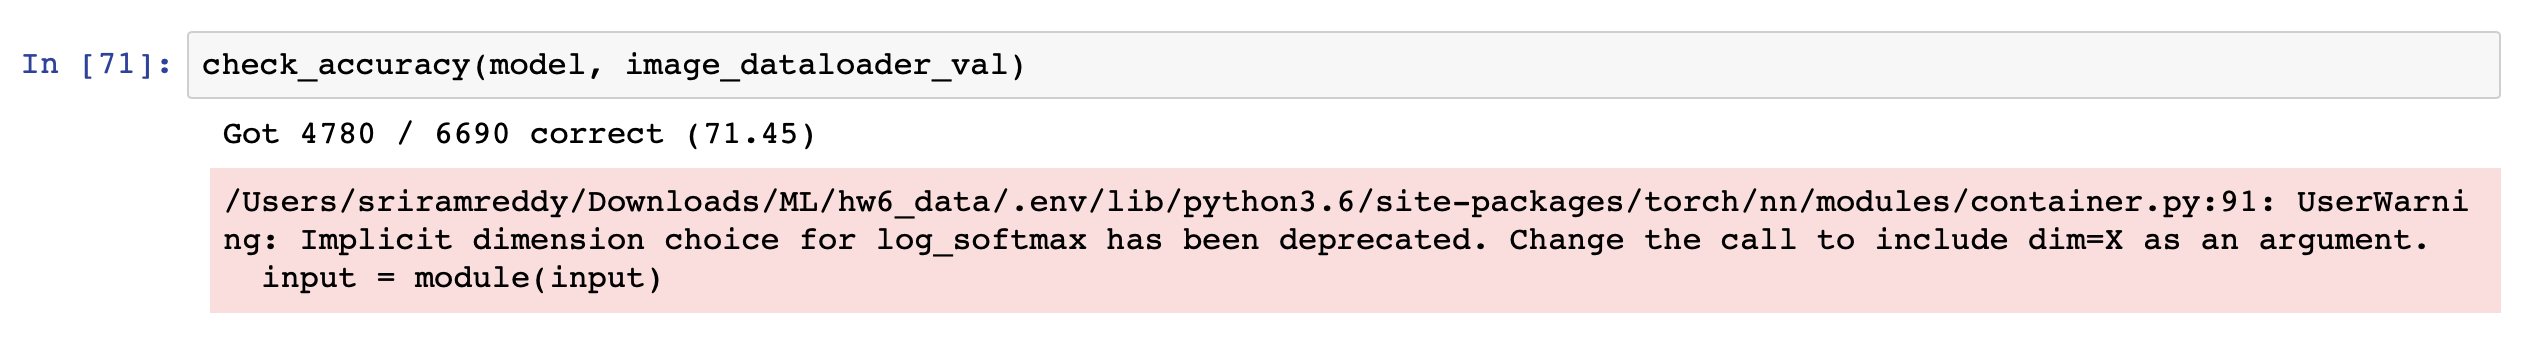

In [2]:
from IPython.display import Image
Image('/Users/sriramreddy/Desktop/accuracyscore1.png')
# ,width=600, height=800)

### Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.

Tell us here!
###########4th TODO (5 points) ##############

I have tried the following things:

1)Training the network using the CNN layer filter from 7 and varying to 5 and 3 by increasing the CNN layers. 
I have observed the training the network is faster for using filter size 3 as the number of parameters in the network is reduced drastically.

2)I have trained the network with and without the batch normalization. I have seen little improvement if I'm using the network with Batch Normalization. 

3)I used data augmentation techniques by adding salt and pepper noise and flipping the pictures. I have uploaded the script for data augmentation in my github. Please find the link below:


It had improved the performance but only 1%.

4)I have played with different Optimization techniques and properly tuned the learning rate. RMSprop and Adam gave decent results.

5)Similarly,I have seen the benefits of drop out as it is helping to reduce the overfit problem because of the training for more epochs. Moreover, I'm fascianted behind the idea of dropout as it came from reproduction in biology.
Using the layers, conv2d, relu, maxpool,Batchnorm and Affine layers, I have constructed seven networks. Out of which, I got the cross validation accuracy i.e best for the model which is given below.

CONV2D -> RELU -> CONV2D -> RELU -> MAXPOOL2D -> BATCH NORM -> DROP OUT ->
CONV2D -> RELU -> MAXPOOL2D ->BATCHNORM -> DROPOUT ->CONV2D -> RELU -> MAX POOL2D ->
BATCHNORM 2D ->FLATTEN -> AFFINE -> RELU -> DROP OUT -> AFFINE -> RELU -> SOFTMAX

Exact description is given as below:
1.	3x3 Convolutional Layer with 64 filters and stride of 1

2.	ReLU Activation Layer

3.	3x3 Convolutional Layer with 64 filters and stride of 1

4.	ReLU Activation Layer

5.	2x2 Max Pooling layer with a stride of 2

6.	Batch Normalization Layer

7.	Drop out layer of 0.1

8.	3x3 Convolutional Layer with 128 filters and stride of 1

9.	ReLU Activation Layer

10.	2x2 Max Pooling layer with a stride of 2

11.	Batch Normalization Layer

12.	Drop out layer of 0.2

13.	5x5 Convolutional Layer with 256 filters and stride of 1

14.	ReLU Activation Layer

15.	2x2 Max Pooling layer with a stride of 2

16.	Batch Normalization Layer

17.	Flatten

18.	Affine layer

19.	ReLU Activation Layer

20.	Drop out layer of 0.2

21.	Affine layer

22.	ReLU Activation Layer

23.	Softmax layer

Affine transformation is nothing but the linear layer with dense connections similar to that of tensorflow. 

The above network is some what similar to VGG Net 19 architecture. 

With the above network, I got cross validation accuracy of 71.45%.


### Testing the model and submit on Kaggle
Testing the model on the testing set and save the results as a .csv file. 
Please submitted the results.csv file generated by predict_on_test() to Kaggle(https://www.kaggle.com/c/cse512springhw3) to see how well your network performs on the test set. 
#######5th TODO (submit the result to Kaggle, the highest 3 entries get extra 10 points )###############

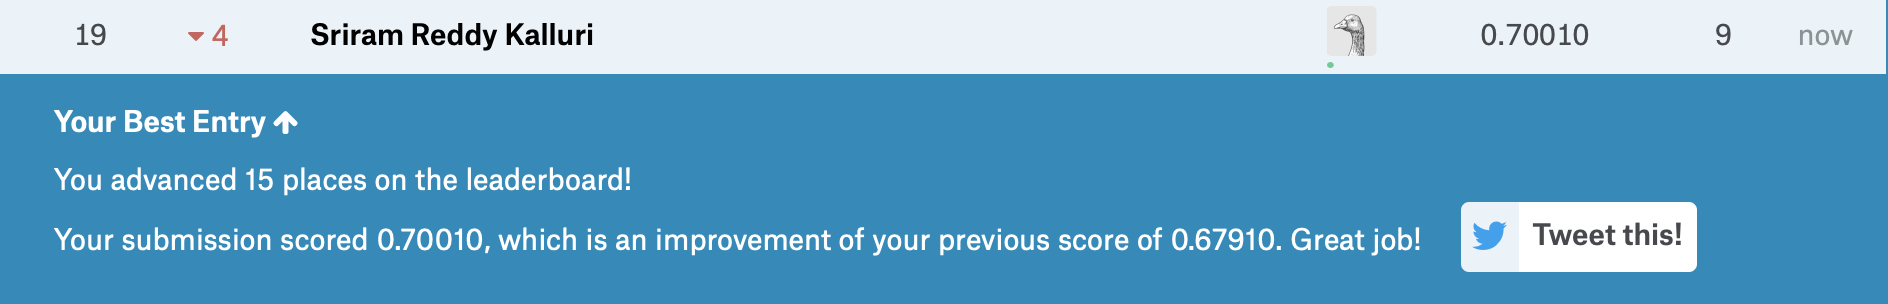

In [3]:
Image('/Users/sriramreddy/Desktop/image_result.png')

In [72]:
def predict_on_test(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    results=open('results_final2.csv','w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    for t, sample in enumerate(loader):
        x_var = Variable(sample['image'])
        scores = model(x_var)
        _, preds = scores.data.max(1)
        for i in range(len(preds)):
            results.write(str(count)+','+str(preds[i])+'\n')
            count+=1
    results.close()
    return count

fixed_model = model
count=predict_on_test(fixed_model, image_dataloader_test)
print(count)

9810


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


### GPU! (This part is optional, 0 points)

If you have access to GPU, you can make the code run on GPU, it would be much faster. 

Now, we're going to switch the dtype of the model and our data to the GPU-friendly tensors, and see what happens... everything is the same, except we are casting our model and input tensors as this new dtype instead of the old one.

If this returns false, or otherwise fails in a not-graceful way (i.e., with some error message), you may not have an NVIDIA GPU available on your machine. 

In [ ]:
# Verify that CUDA is properly configured and you have a GPU available

torch.cuda.is_available()

In [ ]:
import copy
gpu_dtype = torch.cuda.FloatTensor

fixed_model_gpu = copy.deepcopy(fixed_model_base)#.type(gpu_dtype)
fixed_model_gpu.cuda()
x_gpu = torch.randn(4, 3, 64, 64).cuda()#.type(gpu_dtype)
x_var_gpu = Variable(x_gpu)#type(gpu_dtype)) # Construct a PyTorch Variable out of your input data
ans = fixed_model_gpu(x_var_gpu)        # Feed it through the model! 

# Check to make sure what comes out of your model
# is the right dimensionality... this should be True
# if you've done everything correctly
np.array_equal(np.array(ans.size()), np.array([4, 10]))


Run the following cell to evaluate the performance of the forward pass running on the CPU:

In [ ]:
%%timeit 
ans = fixed_model(x_var)

... and now the GPU:

In [ ]:
%%timeit 
torch.cuda.synchronize() # Make sure there are no pending GPU computations
ans = fixed_model_gpu(x_var_gpu)        # Feed it through the model! 
torch.cuda.synchronize() # Make sure there are no pending GPU computations

You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use the GPU datatype for your model and your tensors: as a reminder that is *torch.cuda.FloatTensor* (in our notebook here as *gpu_dtype*)

Let's make the loss function and training variables to GPU friendly format by '.cuda()'

In [ ]:
loss_fn = nn.CrossEntropyLoss().cuda()
optimizer = optim.RMSprop(fixed_model_gpu.parameters(), lr=1e-4)

In [ ]:
def train(model, loss_fn, optimizer, dataloader, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, sample in enumerate(dataloader):
            x_var = Variable(sample['image'].cuda())
            y_var = Variable(sample['Label'].cuda().long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def check_accuracy(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for t, sample in enumerate(loader):
        x_var = Variable(sample['image'].cuda())
        y_var = sample['Label'].cuda()
        y_var=y_var.cpu()
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        #print(preds)
        #print(y_var)
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

Run on GPU!

In [ ]:
torch.cuda.random.manual_seed(12345)

fixed_model_gpu.apply(reset) 
fixed_model_gpu.train() 
train(fixed_model_gpu, loss_fn, optimizer,image_dataloader_train, num_epochs=1) 
check_accuracy(fixed_model_gpu, image_dataloader_train)# check accuracy on the training set


### 3D Convolution on video clips (25 points+10 extra points)
3D convolution is for videos, it has one more dimension than 2d convolution. You can find the document for 3D convolution here http://pytorch.org/docs/master/nn.html#torch.nn.Conv3dIn. In our dataset, each clip is a video of 3 frames. Lets classify the each clip rather than each image using 3D convolution.
We offer the data loader, the train_3d and check_accuracy

In [20]:
class ActionClipDataset(Dataset):
    """Action Landmarks dataset."""

    def __init__(self,  root_dir,labels=[], transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.root_dir = root_dir
        self.transform = transform
        self.length=len(os.listdir(self.root_dir))
        self.labels=labels

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        
        folder=idx+1
        folder=format(folder,'05d')
        clip=[]
        if len(self.labels)!=0:
            Label=self.labels[idx][0]-1
        for i in range(3):
            imidx=i+1
            imgname=str(imidx)+'.jpg'
            img_path = os.path.join(self.root_dir,
                                    folder,imgname)
            image = Image.open(img_path)
            image=np.array(image)
            clip.append(image)
        if self.transform:
            clip=np.asarray(clip)
            clip=np.transpose(clip, (0,3,1,2))
            clip = torch.from_numpy(np.asarray(clip))
        if len(self.labels)!=0:
            sample={'clip':clip,'Label':Label,'folder':folder}
        else:
            sample={'clip':clip,'folder':folder}
        return sample

clip_dataset=ActionClipDataset(root_dir='./data/trainClips/',\
                               labels=label_train,transform=T.ToTensor())#/home/tqvinh/Study/CSE512/cse512-s18/hw2data/trainClips/
for i in range(10):
    sample=clip_dataset[i]
    print(sample['clip'].shape)
    print(sample['Label'])
    print(sample['folder'])

torch.Size([3, 3, 64, 64])
0.0
00001
torch.Size([3, 3, 64, 64])
0.0
00002
torch.Size([3, 3, 64, 64])
0.0
00003
torch.Size([3, 3, 64, 64])
0.0
00004
torch.Size([3, 3, 64, 64])
0.0
00005
torch.Size([3, 3, 64, 64])
0.0
00006
torch.Size([3, 3, 64, 64])
0.0
00007
torch.Size([3, 3, 64, 64])
0.0
00008
torch.Size([3, 3, 64, 64])
0.0
00009
torch.Size([3, 3, 64, 64])
0.0
00010


In [21]:
clip_dataloader = DataLoader(clip_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


for i,sample in enumerate(clip_dataloader):
    print(i,sample['clip'].shape,sample['folder'],sample['Label'])
    if i>20: 
        break

0 torch.Size([4, 3, 3, 64, 64]) ['00848', '04731', '00323', '03170'] tensor([0., 5., 0., 3.], dtype=torch.float64)
1 torch.Size([4, 3, 3, 64, 64]) ['03713', '06089', '07311', '00508'] tensor([4., 7., 9., 0.], dtype=torch.float64)
2 torch.Size([4, 3, 3, 64, 64]) ['06913', '02345', '04267', '04541'] tensor([8., 2., 5., 5.], dtype=torch.float64)
3 torch.Size([4, 3, 3, 64, 64]) ['02668', '05548', '06420', '07537'] tensor([2., 6., 7., 9.], dtype=torch.float64)
4 torch.Size([4, 3, 3, 64, 64]) ['04443', '01097', '03435', '03473'] tensor([5., 1., 3., 3.], dtype=torch.float64)
5 torch.Size([4, 3, 3, 64, 64]) ['04056', '03056', '04982', '03035'] tensor([4., 3., 6., 3.], dtype=torch.float64)
6 torch.Size([4, 3, 3, 64, 64]) ['02348', '06924', '03008', '07338'] tensor([2., 8., 3., 9.], dtype=torch.float64)
7 torch.Size([4, 3, 3, 64, 64]) ['02546', '03775', '06399', '03798'] tensor([2., 4., 7., 4.], dtype=torch.float64)
8 torch.Size([4, 3, 3, 64, 64]) ['02593', '03687', '01732', '06350'] tensor([2.,

In [22]:
clip_dataset_train=ActionClipDataset(root_dir='./data/trainClips/',labels=label_train,transform=T.ToTensor())

clip_dataloader_train = DataLoader(clip_dataset_train, batch_size=16,
                        shuffle=True, num_workers=4)
clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=T.ToTensor())

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=16,
                        shuffle=True, num_workers=4)
clip_dataset_test=ActionClipDataset(root_dir='./data/testClips/',labels=[],transform=T.ToTensor())

clip_dataloader_test = DataLoader(clip_dataset_test, batch_size=16,
                        shuffle=False, num_workers=4)

Write the Flatten for 3d covolution feature maps.

In [32]:
class Flatten3d(nn.Module):
    def forward(self, x):
        N, C, T, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
        
        ###############6th TODO (5 points)###################
        

Design a network using 3D convolution on videos for video classification.

In [34]:
fixed_model_3d = nn.Sequential( # You fill this in!
    ###############7th TODO (20 points)#########################
 nn.Conv3d(3, 32, kernel_size=(1,5,5), stride=1),
#     32*60*60
                nn.ReLU(inplace=True),
                nn.MaxPool3d((1,2,2), stride = (1,2,2)),
    #32*30*30
                nn.BatchNorm3d(32),
                nn.Dropout3d(0.1),
                nn.Conv3d(32, 24, kernel_size=(1,5,5), stride=1),
    #24*26*26
                nn.ReLU(inplace=True),
                nn.MaxPool3d((1,2,2), stride = (1,2,2)),
                nn.BatchNorm3d(24),
    #24*13*13
                nn.Dropout3d(0.2),
                nn.Conv3d(24, 20, kernel_size=(1,4,4), stride=1),
#     20*10*10
                nn.ReLU(inplace=True),
                nn.MaxPool3d((1,2,2), stride = (1,2,2)),
    #20*5*5
                nn.BatchNorm3d(20),
                Flatten3d(),
                nn.Linear(1500, 500),
                nn.Linear(500, 100),
                nn.Linear(100, 50),
                nn.Linear(50, 10),
                nn.LogSoftmax() )

fixed_model_3d = fixed_model_3d.type(dtype)
x = torch.randn(32,3, 3, 64, 64).type(dtype)
x_var = Variable(x).type(dtype) # Construct a PyTorch Variable out of your input data
ans = fixed_model_3d(x_var) 
np.array_equal(np.array(ans.size()), np.array([32, 10]))


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


True

### Describe what you did (5 points)

In the cell below you should write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network.


### 8th TODO Tell us here:

I have implemented the best 3 architectures from the image classification and tweaked the parameters corresponding for the 3d by using the strides and kernel sizes accordingly. What I observed was, the training time is more as it involves one more dimension for video. 

Please find the best architecture below:

by considering the frame parameter which is one extra dimension to an image. 

 1. Conv3d with 32 channels kernel_size=(1,5,5), stride=(1,1,1)
 2. Re LU Activation Layer
 3. Max pooling 3d with filter size 1,2,2 and stride 1,2,2
 4. Batch Normalization Layer
 5. Drop out layer with 0.1 percentage
 6. Conv3d with 24 channels kernel_size=(1,5,5), stride=(1,1,1)
 7. Re LU Activation Layer
 8. Max pooling 3d with filter size 1,2,2 and stride 1,2,2
 9. Batch Normalization Layer
 10. Drop out layer with 0.2 percentage
 11. Conv3d with 20 channels kernel_size=(1,4,4), stride=(1,1,1)
 12. Re LU Activation Layer
 13. Max pooling 3d with filter size 1,2,2 and stride 1,2,2
 14. Batch Normalization Layer
 15. Flatten 3d
 16. Affine layer connecting 1500 to 500
 17. Affine layer connecting 500 to 100
 18. Affine layer connecting 100 to 50
 19. Affine layer connecting 50 to 10
 20. Soft max layer
 
The above network gave cross validation accuracy of 69.10%






In [35]:
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.RMSprop(fixed_model_3d.parameters(), lr=1e-4)


In [36]:
def train_3d(model, loss_fn, optimizer,dataloader,num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, sample in enumerate(dataloader):
            x_var = Variable(sample['clip'].type(dtype))
            y_var = Variable(sample['Label'].type(dtype).long())

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def check_accuracy_3d(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for t, sample in enumerate(loader):
        x_var = Variable(sample['clip'].type(dtype))
        y_var = sample['Label'].type(dtype)
        y_var=y_var.cpu()
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        #print(preds)
        #print(y_var)
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [38]:
torch.cuda.random.manual_seed(12345)
fixed_model_3d.apply(reset) 
fixed_model_3d.train() 
train_3d(fixed_model_3d, loss_fn, optimizer,clip_dataloader_train, num_epochs=8) 
fixed_model_3d.eval() 
check_accuracy_3d(fixed_model_3d, clip_dataloader_val)

Starting epoch 1 / 8


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


t = 100, loss = 1.5388
t = 200, loss = 1.4160
t = 300, loss = 0.9735
t = 400, loss = 0.8717
Starting epoch 2 / 8
t = 100, loss = 1.0365
t = 200, loss = 0.8146
t = 300, loss = 1.1443
t = 400, loss = 0.7251
Starting epoch 3 / 8
t = 100, loss = 0.2995
t = 200, loss = 0.1649
t = 300, loss = 0.2752
t = 400, loss = 0.3877
Starting epoch 4 / 8
t = 100, loss = 0.2216
t = 200, loss = 0.2135
t = 300, loss = 0.2636
t = 400, loss = 0.0387
Starting epoch 5 / 8
t = 100, loss = 0.0989
t = 200, loss = 0.3504
t = 300, loss = 0.2990
t = 400, loss = 0.1520
Starting epoch 6 / 8
t = 100, loss = 0.1962
t = 200, loss = 0.3128
t = 300, loss = 0.1248
t = 400, loss = 0.0925
Starting epoch 7 / 8
t = 100, loss = 0.0495
t = 200, loss = 0.0629
t = 300, loss = 0.0537
t = 400, loss = 0.0409
Starting epoch 8 / 8
t = 100, loss = 0.2107
t = 200, loss = 0.1300
t = 300, loss = 0.0620
t = 400, loss = 0.0609
Got 1534 / 2230 correct (68.79)


In [40]:
train_3d(fixed_model_3d, loss_fn, optimizer,clip_dataloader_train, num_epochs=3) 

Starting epoch 1 / 3


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


t = 100, loss = 0.4062
t = 200, loss = 0.2293
t = 300, loss = 0.1897
t = 400, loss = 0.2072
Starting epoch 2 / 3
t = 100, loss = 0.1088
t = 200, loss = 0.0010
t = 300, loss = 0.0311
t = 400, loss = 0.0183
Starting epoch 3 / 3
t = 100, loss = 0.0063
t = 200, loss = 0.1303
t = 300, loss = 0.0245
t = 400, loss = 0.2597


In [41]:
fixed_model_3d.eval() 
check_accuracy_3d(fixed_model_3d, clip_dataloader_val)

Got 1414 / 2230 correct (63.41)


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [42]:
train_3d(fixed_model_3d, loss_fn, optimizer,clip_dataloader_train, num_epochs=1) 

Starting epoch 1 / 1


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


t = 100, loss = 0.1027
t = 200, loss = 0.0166
t = 300, loss = 0.0193
t = 400, loss = 0.0288


In [43]:
fixed_model_3d.eval() 
check_accuracy_3d(fixed_model_3d, clip_dataloader_val)

Got 1541 / 2230 correct (69.10)


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test your 3d convolution model on the validation set. You don't need to submit the result of this part to kaggle.  

Test your model on the test set, predict_on_test_3d() will generate a file named 'results_3d.csv'. Please submit the csv file to kaggle https://www.kaggle.com/c/cse512springhw3video
The highest 3 entries get extra 10 points.


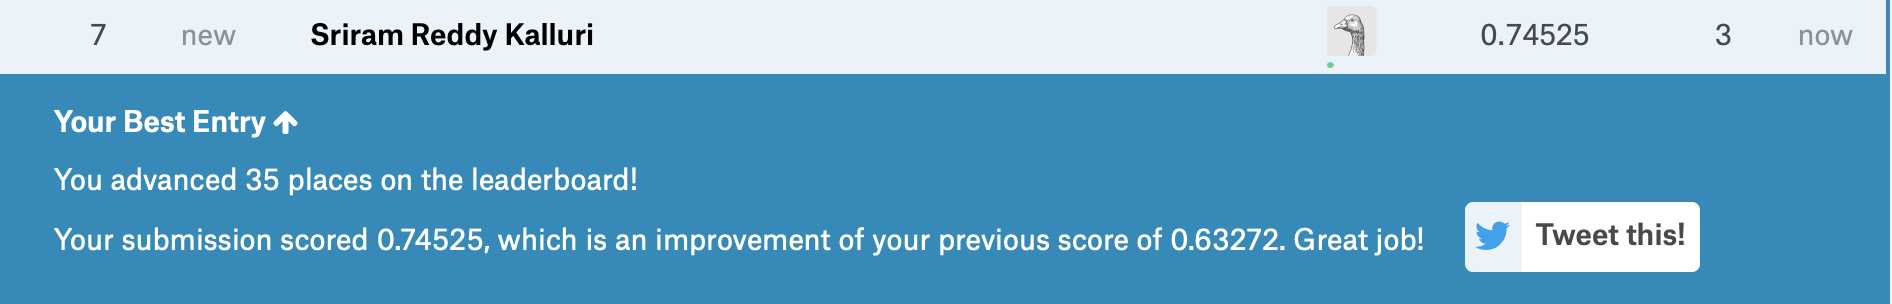

In [5]:
Image('/Users/sriramreddy/Desktop/video_result.png')

In [44]:
def predict_on_test_3d(model, loader):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    results=open('results_3d_2.csv','w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    for t, sample in enumerate(loader):
        x_var = Variable(sample['clip'].type(dtype))
        scores = model(x_var)
        _, preds = scores.data.max(1)
        for i in range(len(preds)):
            results.write(str(count)+','+str(preds[i])+'\n')
            count+=1
    results.close()
    return count
    
count=predict_on_test_3d(fixed_model_3d, clip_dataloader_test)
print(count)

3270


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [46]:
fixed_model_3d = nn.Sequential( # You fill this in!
    ###############7th TODO (20 points)#########################
 nn.Conv3d(3, 32, kernel_size=(1,3,3), stride=1),
#     32*62*62
                nn.ReLU(inplace=True),
     nn.Conv3d(32, 32, kernel_size=(1,5,5), stride=1),
    nn.ReLU(inplace=True),
    #32*58*58
                nn.MaxPool3d((1,3,3), stride = (1,1,1)),
#32*56*56
                nn.BatchNorm3d(32),
                nn.Dropout3d(0.1),
                nn.Conv3d(32, 24, kernel_size=(1,5,5), stride=1),
    #24*52*52
                nn.ReLU(inplace=True),
                nn.MaxPool3d((1,2,2), stride = (1,2,2)),
                nn.BatchNorm3d(24),
    #24*26*26
                nn.Dropout3d(0.2),
                nn.Conv3d(24, 10, kernel_size=(1,5,5), stride=1),
#     10*22*22
                nn.ReLU(inplace=True),
                nn.MaxPool3d((1,2,2), stride = (1,2,2)),
    #10*11*11*3
                nn.BatchNorm3d(10),    
                Flatten3d(),
                nn.Linear(3630, 500),
                nn.Linear(500, 100),
                nn.Linear(100, 50),
                nn.Linear(50, 10),
                nn.LogSoftmax())

fixed_model_3d = fixed_model_3d.type(dtype)
x = torch.randn(32,3, 3, 64, 64).type(dtype)
x_var = Variable(x).type(dtype) # Construct a PyTorch Variable out of your input data
ans = fixed_model_3d(x_var) 
np.array_equal(np.array(ans.size()), np.array([32, 10]))

/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


True

In [49]:
# t = 100, loss = 2.3200
# t = 200, loss = 2.3111
# t = 300, loss = 2.2980
# t = 400, loss = 2.3177
torch.cuda.random.manual_seed(12345)
fixed_model_3d.apply(reset) 
fixed_model_3d.train() 
train_3d(fixed_model_3d, loss_fn, optimizer,clip_dataloader_train, num_epochs=8) 
fixed_model_3d.eval() 
check_accuracy_3d(fixed_model_3d, clip_dataloader_val)

In [ ]:
count=predict_on_test_3d(fixed_model_3d, clip_dataloader_test)
print(count)

In [48]:
check_accuracy_3d(fixed_model_3d, clip_dataloader_val)

Got 167 / 2230 correct (7.49)


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
fixed_model_3d = nn.Sequential( # You fill this in!
    ###############7th TODO (20 points)#########################
    nn.Conv3d(3, 32, kernel_size=(1,3,3), stride=1),
#     32*62*62
                nn.ReLU(inplace=True),
                nn.MaxPool3d((1,2,2), stride = (1,2,2)),
    #32*31*31
                nn.BatchNorm3d(32),
                nn.Dropout3d(0.1),
                nn.Conv3d(32, 24, kernel_size=(1,5,5), stride=1),
    #24*26*26
                nn.ReLU(inplace=True),
                nn.MaxPool3d((1,2,2), stride = (1,2,2)),
                nn.BatchNorm3d(24),
    #24*13*13
                nn.Dropout3d(0.2),
                nn.Conv3d(24, 20, kernel_size=(1,4,4), stride=1),
#     20*10*10
                nn.ReLU(inplace=True),
                nn.MaxPool3d((1,2,2), stride = (1,2,2)),
    #20*5*5
                nn.BatchNorm3d(20),
                Flatten3d(),
                nn.Linear(1500, 500),
                nn.Linear(500, 100),
                nn.Linear(100, 50),
                nn.Linear(50, 10),
                nn.LogSoftmax() )
    
    
    
    
 nn.Conv3d(3, 32, kernel_size=(1,3,3), stride=1),
#     32*62*62
                nn.ReLU(inplace=True),
     nn.Conv3d(32, 32, kernel_size=(1,5,5), stride=1),
    nn.ReLU(inplace=True),
    #32*58*58
                nn.MaxPool3d((1,3,3), stride = (1,1,1)),
#32*56*56
                nn.BatchNorm3d(32),
                nn.Dropout3d(0.1),
                nn.Conv3d(32, 24, kernel_size=(1,5,5), stride=1),
    #24*52*52
                nn.ReLU(inplace=True),
                nn.MaxPool3d((1,2,2), stride = (1,2,2)),
                nn.BatchNorm3d(24),
    #24*26*26
                nn.Dropout3d(0.2),
                nn.Conv3d(24, 10, kernel_size=(1,5,5), stride=1),
#     10*22*22
                nn.ReLU(inplace=True),
                nn.MaxPool3d((1,2,2), stride = (1,2,2)),
    #10*11*11*3
                nn.BatchNorm3d(10),    
                Flatten3d(),
                nn.Linear(3630, 500),
                nn.Linear(500, 100),
                nn.Linear(100, 50),
                nn.Linear(50, 10),
                nn.LogSoftmax())

fixed_model_3d = fixed_model_3d.type(dtype)
x = torch.randn(32,3, 3, 64, 64).type(dtype)
x_var = Variable(x).type(dtype) # Construct a PyTorch Variable out of your input data
ans = fixed_model_3d(x_var) 
np.array_equal(np.array(ans.size()), np.array([32, 10]))

In [56]:
fixed_model_3d =  nn.Sequential(     
    nn.Conv3d(3, 32, kernel_size=(1,3,3), stride=1),
    nn.ReLU(inplace=True),
    nn.Conv3d(32, 32, kernel_size=(1,3,3), stride=1),
    nn.ReLU(inplace=True),  
#     32*60*60
                nn.MaxPool3d((1,2,2), stride = (1,2,2)),
    #32*30*30
            nn.BatchNorm3d(32),
                nn.Dropout3d(0.1),
                nn.Conv3d(32, 64, kernel_size=(1,3,3), stride=1),
    #64*28*28
                nn.ReLU(inplace=True),
                nn.MaxPool3d((1,2,2), stride = (1,2,2)),
                nn.BatchNorm3d(64),
    #64*14*14
                nn.Dropout3d(0.2),
                nn.Conv3d(64, 128, kernel_size=(1,5,5), stride=1),
#     128*10*10
                nn.ReLU(inplace=True),
                nn.MaxPool3d((1,2,2), stride=(1,2,2)),
    #128*5*5
                nn.BatchNorm3d(128),
                Flatten3d(),
                nn.Linear(9600, 1000),
                nn.ReLU(inplace=True),
                nn.Dropout3d(0.1),
                nn.Linear(1000, 10),
                nn.ReLU(inplace=True),
                nn.LogSoftmax())
    
    
torch.cuda.random.manual_seed(12345)
fixed_model_3d.apply(reset) 
fixed_model_3d.train() 
train_3d(fixed_model_3d, loss_fn, optimizer,clip_dataloader_train, num_epochs=1) 
fixed_model_3d.eval() 
check_accuracy_3d(fixed_model_3d, clip_dataloader_val)

Starting epoch 1 / 1


/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/Users/sriramreddy/Downloads/ML/hw6_data/.env/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


t = 100, loss = 2.3164
t = 200, loss = 2.2735
t = 300, loss = 2.3118
t = 400, loss = 2.2758
Got 349 / 2230 correct (15.65)


In [58]:
train_3d(fixed_model_3d, loss_fn, optimizer,clip_dataloader_train, num_epochs=8) 
fixed_model_3d.eval() 
check_accuracy_3d(fixed_model_3d, clip_dataloader_val)

# t = 100, loss = 2.3102
# t = 200, loss = 2.2599
# t = 300, loss = 2.2938
# t = 400, loss = 2.2512
# Starting epoch 2 / 8
# t = 100, loss = 2.2931
# t = 200, loss = 2.3002
# t = 300, loss = 2.2783
# t = 400, loss = 2.3208
# Starting epoch 3 / 8
# t = 100, loss = 2.3123
# t = 200, loss = 2.3170
# t = 300, loss = 2.2825

In [59]:
# Some how the same Resnet model is not decreasing.
# Earlier model behaves way better.